# Designing Communication Topologies via Graph Neural Networks
Fengjun Yang, Nikolai Matni (2021)

In [290]:
%load_ext autoreload
%autoreload 2

# Useful Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import networkx as nx

# Source Files
import grnn, exp_utils, controller
import env.dlqr

# Other bookkeeping
%matplotlib inline
np.set_printoptions(precision=3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## How to train and run the GRNN model

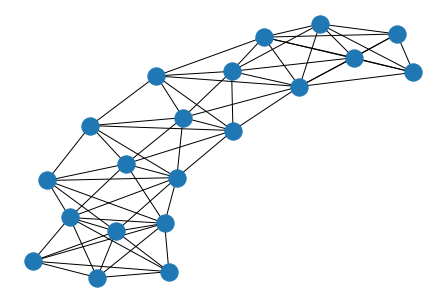

In [302]:
# Create an environment
N = 20
T = 50
p, q = 1, 1
degree = 5 + 1     # All nodes are assumed to have a self-loop, hence the +1

# Generate environment (here an LQR environment)
dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
nx.draw_kamada_kawai(G)

In [303]:
# Define training loss
def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)

In [304]:
# Create model
hidden_state_dim = 5
S = dlqrenv.S.clone()
model = grnn.GRNN(S, N, T, p, q, hidden_state_dim, S_trainable=True).to(device)

In [305]:
# Train model
model = exp_utils.train_model(model, dlqrenv, criterion, num_epoch=100, verbose=True)

Epoch: 1 	 Loss: 12607.163254153878
Epoch: 11 	 Loss: 8334.076001731848
Epoch: 21 	 Loss: 4526.931087735424
Epoch: 31 	 Loss: 2395.298067769477
Epoch: 41 	 Loss: 827.7538234830508
Epoch: 51 	 Loss: 41.20836410333345
Epoch: 61 	 Loss: 30.890883545272423
Epoch: 71 	 Loss: 26.67543129086951
Epoch: 81 	 Loss: 28.067213893805558
Epoch: 91 	 Loss: 28.787809698198224


In [300]:
# Define controllers we want to compare to
lqrctrl = dlqrenv.get_optimal_controller()
grnnctrl = model.get_controller(batch_size=1)
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
controllers = [lqrctrl, grnnctrl, zeroctrl, randctrl]
names = ['Global Optimal', 'GRNN', 'Autonomous', 'Random']

In [307]:
# Simulate each controller forward from the same initial condition
x0 = dlqrenv.random_x0()
xs, us, costs = exp_utils.sim_controllers(dlqrenv, x0, controllers, T, x0.device)
exp_utils.plot_controllers(xs, names, costs, 0)

ValueError: too many values to unpack (expected 4)

## Experiment 1: GRNN on LQR Systems with Given Communication Topology

In [91]:
# Parameters for the model
N, degree, T, p, q, h = 20, 5+1, 50, 1, 1, 5
model_params = {'N':N,'T':T, 'p':p, 'q':p, 'h':5, 'S_trainable':True}

training_params = {
    'criterion': criterion, 'T': T, 'device': device,
    'num_epoch': 100, 'batch_size': 20, 'ensemble_size': 2, 'val_size': 50}
use_given_support = True

# Additional controllers to compare to
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
additional_controllers = [zeroctrl, randctrl]
num_controllers = len(additional_controllers) + 2

# Training loss
def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)

# Experiment parameters
num_topologies = 50
num_x0s = 100
num_epoch = 100
verbose = True

In [ ]:
# Evaluate the performance of GRNN
total_rel_costs = np.zeros(num_controllers)

rel_costs_table = np.zeros((num_topologies, num_controllers))
envs = []

for counter in range(num_topologies):
    # Generate an environment
    dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
    model = exp_utils.generate_model(model_params, dlqrenv,
                                     use_given_support=use_given_support, S=dlqrenv.S.clone(),
                                     **training_params)
    
    # Test the performance of GRNN on this env
    rel_costs = exp_utils.estimate_grnn_cost(
        dlqrenv, model, T, additional_controllers, num_x0s=num_x0s)
    total_rel_costs += rel_costs
    
    rel_costs_table[counter] = rel_costs
    envs.append(dlqrenv)

    # Print progress
    if verbose:
        print('Iteration {}:\t{}\t{}'.format(counter+1, rel_costs, total_rel_costs / (counter+1)))

# Print result
print(total_rel_costs / num_topologies)

## Experiment 2: Generate Communication Topology w/ GRNN

In [93]:
# Parameters for the model
N, degree, T, p, q, h = 20, 5+1, 50, 1, 1, 5
model_params = {'N':N,'T':T, 'p':p, 'q':p, 'h':5, 'S_trainable':True}

# Define Training loss
def sparse_criterion(x_traj, u_traj, env, model):
    global beta
    return env.cost(x_traj, u_traj) + beta * torch.sum(torch.abs(model.S_()))

def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)

sparse_params = {
    'criterion': sparse_criterion, 'T': T, 'device': device,
    'num_epoch': 100, 'batch_size': 20, 'ensemble_size': 2, 'val_size': 50
}
training_params = {
    'criterion': criterion, 'T': T, 'device': device,
    'num_epoch': 100, 'batch_size': 20, 'ensemble_size': 2, 'val_size': 50
}

# Additional controllers to compare to
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
additional_controllers = [zeroctrl, randctrl]
num_controllers = len(additional_controllers) + 2

# Experiment parameters
verbose = True
threshold = 1e-3
betas = np.logspace(-5, 2, 10)

In [59]:
S_weights = np.zeros((len(betas), N*N))
reg_costs = np.zeros(len(betas))
retrain_costs = np.zeros(len(betas))

dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
for i, beta in enumerate(betas):
    print('Beta:', beta)
    
    # Train on full support to get a model and topology
    grnn_S, model = exp_utils.grnn_topology(
        dlqrenv, model_params, sparse_params)
    S_weights[i] = grnn_S.cpu().numpy().flatten()
    reg_costs[i] = exp_utils.estimate_grnn_cost(dlqrenv, model, T)[1]
    
    # Retrain the model
    new_S = grnn_S.clone()
    new_S[new_S < threshold] = 0    
    model = exp_utils.generate_model(model_params, dlqrenv, use_given_support=True,
                                     S=new_S, **training_params)
    retrain_costs[i] = exp_utils.estimate_grnn_cost(dlqrenv, model, T)[1]

Beta: 1e-05
Beta: 5.994842503189409e-05
Beta: 0.00035938136638046257
Beta: 0.0021544346900318843
Beta: 0.01291549665014884
Beta: 0.0774263682681127
Beta: 0.4641588833612782
Beta: 2.782559402207126
Beta: 16.68100537200059
Beta: 100.0


Text(0, 0.5, 'LQR Cost')

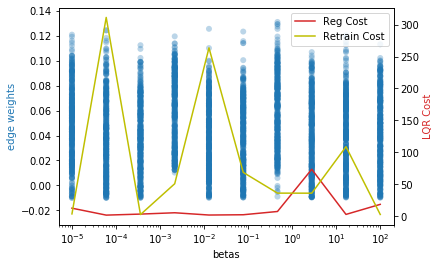

In [71]:
fig = plt.figure()
ax = plt.gca()

for i, beta in enumerate(betas):
    ax.scatter(np.ones(N*N)*beta, S_weights[i], c='tab:blue', alpha=0.3, edgecolors='none')
ax.set_xscale('log')
plt.xlim([betas[0]/2, betas[-1]*2])
ax.set_xlabel('betas')
ax.set_ylabel('edge weights', color='tab:blue')

ax2 = ax.twinx()
ax2.plot(betas, reg_costs, c='tab:red', label='Reg Cost')
ax2.plot(betas, retrain_costs, c='y', label='Retrain Cost')
ax2.legend()

ax2.set_ylabel('LQR Cost', color='tab:red')
#plt.savefig('losssparsity.png', dpi=300)

In [113]:
##################################
num_topologies = 2
threshold = 1e-3
##################################
num_edges = np.zeros(len(betas))
reg_costs = np.zeros(len(betas))
retrain_costs = np.zeros(len(betas))

for j in range(num_topologies):
    print('Topology: {}'.format(j))
    dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
    for i, beta in enumerate(betas):
        # Train on full support to get a model and topology
        grnn_S, model = exp_utils.grnn_topology(
            dlqrenv, model_params, sparse_params)
        reg_costs[i] += exp_utils.estimate_grnn_cost(dlqrenv, model, T)[1]

        # Retrain the model
        new_S = grnn_S.clone()
        new_S[new_S < threshold] = 0
        num_edges[i] += torch.sum(new_S > threshold).item()
        model = exp_utils.generate_model(model_params, dlqrenv, use_given_support=True,
                                         S=new_S, **training_params)
        retrain_costs[i] += exp_utils.estimate_grnn_cost(dlqrenv, model, T)[1]

num_edges = num_edges / num_topologies
reg_costs = reg_costs/ num_topologies
retrain_costs = retrain_costs/ num_topologies

print(num_edges)
print(reg_costs)
print(retrain_costs)

Topology: 0
Topology: 1
[380.  358.5 366.  376.5 362.5 358.  363.5 369.  358.5 362.5]
[ 6.32   1.608 46.683 45.768  1.521  1.109  5.293 25.77   1.302  1.269]
[159.984 104.594   2.782   1.981   1.694   1.226   2.511   1.196   1.107
  30.696]


Text(0, 0.5, 'LQR Cost')

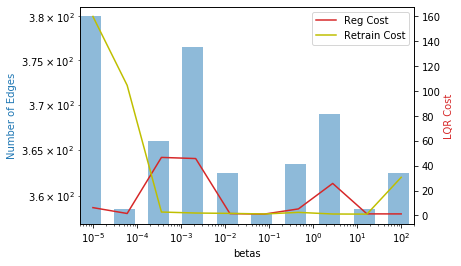

In [114]:
fig = plt.figure()
ax = plt.gca()

ax.bar(betas, num_edges, width=1*betas, log=True, alpha=0.5, color='tab:blue')
ax.set_xscale('log')
plt.xlim([betas[0]/2, betas[-1]*2])
ax.set_xlabel('betas')
ax.set_ylabel('Number of Edges', color='tab:blue')

ax2 = ax.twinx()
ax2.plot(betas, reg_costs, c='tab:red', label='Reg Cost')
ax2.plot(betas, retrain_costs, c='y', label='Retrain Cost')
ax2.legend()

ax2.set_ylabel('LQR Cost', color='tab:red')
#plt.savefig('losssparsity.png', dpi=300)

## Experiment 3: Unstable A

In [80]:
# Parameters for the model
N, degree, T, p, q, h = 20, 5+1, 50, 1, 1, 5
model_params = {'N':N,'T':T, 'p':p, 'q':p, 'h':5, 'S_trainable':True}

# Training loss
def stable_criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj) + env.instability_cost(x_traj, rho=.7)
stable_params = {
    'criterion': stable_criterion,'T': T,'device': device,'num_epoch': 100,'batch_size': 20,
    'ensemble_size': 2,'val_size': 50,
}

def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)
training_params = {
    'criterion': criterion,'T': T,'device': device,'num_epoch': 100,'batch_size': 20,
    'ensemble_size': 2,'val_size': 50,
}
use_given_support = True

# Additional controllers to compare to
zeroctrl = controller.ZeroController(N, q)
additional_controllers = [zeroctrl]
num_controllers = len(additional_controllers) + 2

# Experiment parameters
num_topologies = 50
verbose = True
AB_norms = [1.05, 1.1]
num_x0s = 100

In [81]:
costs = np.zeros((len(AB_norms),3))

for i, norm in enumerate(AB_norms):
    print('-'*20, '\nNorm:', norm)
    
    # Evaluate the performance of GRNN
    total_rel_costs = np.zeros(4)
    stable_total_rel_costs = np.zeros(4)

    for counter in range(num_topologies):
        # Generate an environment
        dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device, A_norm=norm, B_norm=norm)
        model = exp_utils.generate_model(model_params, dlqrenv,
                                         use_given_support=use_given_support, S=dlqrenv.S.clone,
                                         **training_params)
        stable_model = exp_utils.generate_model(model_params, dlqrenv,
                                         use_given_support=use_given_support, S=dlqrenv.S.clone,
                                                **stable_params)

        # Test the performance of GRNN on this env
        rel_costs = exp_utils.estimate_grnn_cost(
            dlqrenv, model, T, [stable_model.get_controller()]+additional_controllers, num_x0s=num_x0s)
        
        total_rel_costs += rel_costs

        # Print progress
        if verbose:
            print('Iteration {}: {}\t{}'.format(counter+1, rel_costs, total_rel_costs/(counter+1)))

    costs[i] = total_rel_costs[1:] / (counter+1)

-------------------- 
Norm: 1.05
Iteration 1: [1.    1.083 1.088 9.928]	[1.    1.083 1.088 9.928]
Iteration 2: [ 1.     1.141  1.157 56.384]	[ 1.     1.112  1.122 33.156]
Iteration 3: [ 1.     1.317  1.298 52.489]	[ 1.     1.18   1.181 39.6  ]
Iteration 4: [ 1.     1.147  1.147 56.678]	[ 1.     1.172  1.172 43.87 ]
Iteration 5: [1.    1.268 1.416 4.312]	[ 1.     1.191  1.221 35.958]


KeyboardInterrupt: 